# Address Classification with Machine Learning

## Overview
This notebook demonstrates an end-to-end machine learning pipeline for classifying noisy address strings into predefined categories. The goal is to improve accuracy and scalability over a rule-based (regex) baseline when handling large volumes of address-based service requests.

## Approach
1. Establish a regex-based baseline
2. Train a supervised ML classifier on labeled address data
3. Compare performance using accuracy, precision, recall, and F1-score
4. Analyze misclassifications and identify improvement opportunities


#### **How to Proceed**

1. Setup and Dataset Loading
2. Method 1: Regex-Based Classification
3. Method 2: ML Based Classification (Decision Tree)
4. Model Comparison

### <font color='dark green'>Setup </font>



1. `pandas`: Handles the dataset, allowing easy loading, viewing, and manipulation of tabular data.
2. `re`: Applies rule-based classification using pattern matching in text.
3. `train_test_split`: Divides the dataset into training and testing subsets for unbiased evaluation.
4. `CountVectorizer`: Converts textual data into a numerical data.
5. `DecisionTreeClassifier`: Performs classification on the dataset.
6. `classification_report`: Measure model performance using metrics like precision, recall, f1 and accuracy.

In [8]:
# @title Importing Libraries
# Importing Libraries

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Data Availability Note

The full training and test datasets used in this project are not included in this repository due to size and data sensitivity considerations.

This notebook demonstrates the complete machine learning workflow, including preprocessing, model training, evaluation, and comparison. To run the notebook end-to-end, provide CSV files with the following schema:

- `address` (string)
- `category` (label for training data)

Sample data structure is described below.


In [ ]:
# @title Function to load the train and test dataset
# Upload the datasets provided into Colab.

def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

# Load data
try:
    train_df, test_df = load_data(
        "10k_Address_manual_reviewed.csv",
        "15k_Address_unlabeled.csv"
    )
except FileNotFoundError:
    print("Dataset files not found. See Data Availability Note above.")
    train_df, test_df = None, None


<font color='blue'>**regex_patterns** </font>

    "Business": r"\b(?:Suite|Office|Building|Center)\s?\d*\b",                                                                                              # Matches business-related terms with optional numbers.
    "Shared": r"\b(?:Apt|Unit|Fl|Floor)\s?\d*\b",                                                                                                           # Matches shared living spaces like apartments or units.
    "Multiple": r"\b\d+\s\w+\s(?:St|Ave|Blvd|Way|Dr|Rd|Ln|Pkwy|Terr|Plz|Pl)(?:\sand\s\d+\s\w+\s(?:St|Ave|Blvd|Way|Dr|Rd|Ln|Pkwy|Terr|Plz|Pl))\b",           # Matches multiple valid address aliases.
    "Duplicate": r"\b\d+\s\w+\s(?:St|Ave|Blvd|Way|Dr|Rd|Ln|Pkwy|Terr|Plz|Pl)$",                                                                             # Matches repeated identical addresses.
    "Others": r"\b(?:PO\sBox\s\d+|Corner\sof\s\w+\s(?:St|Ave)|Street\sUnknown|Undetermined)\b"                                                              # Matches incomplete or unverifiable addresses.


The Below used function applies regex patterns to classify each address into a predefined category.

**Key Logic:**
*   **String Check:** Ensures the input address is a string. If not, it's automatically classified as "Others". This handles cases where the data might contain NaN or other non-string entries.
*   **Regex Matching:** Iterates over the regex_patterns dictionary and applies each pattern to the given address using re.search().
*   **Return Category:** Returns the category of the first matching pattern. If no patterns match, the address is classified as "Others".

### <font color='dark green'>Applying Regex </font>

In [10]:
# @title Classify address text into predefined categories using regex patterns
"""
Classify address text into predefined categories using regex patterns that identify keywords, structures, or formats. Categories include 'Business,' 'Shared,' 'Multiple,' 'Duplicate,' and 'Others,' with specific matching criteria for each.
"""
# Define regex patterns for classification
# Each pattern matches specific keywords or structures that characterize the category.

regex_patterns = {
    "Business": r"\b(?:Suite|Office|Building|Center)\s?\d*\b",                                                                                              # Matches business-related terms with optional numbers.
    "Shared": r"\b(?:Apt|Unit|Fl|Floor)\s?\d*\b",                                                                                                           # Matches shared living spaces like apartments or units.
    "Multiple": r"\b\d+\s\w+\s(?:St|Ave|Blvd|Way|Dr|Rd|Ln|Pkwy|Terr|Plz|Pl)(?:\sand\s\d+\s\w+\s(?:St|Ave|Blvd|Way|Dr|Rd|Ln|Pkwy|Terr|Plz|Pl))\b",           # Matches multiple valid address aliases.
    "Duplicate": r"\b\d+\s\w+\s(?:St|Ave|Blvd|Way|Dr|Rd|Ln|Pkwy|Terr|Plz|Pl)$",                                                                             # Matches repeated identical addresses.
    "Others": r"\b(?:PO\sBox\s\d+|Corner\sof\s\w+\s(?:St|Ave)|Street\sUnknown|Undetermined)\b"                                                              # Matches incomplete or unverifiable addresses.
}

In [ ]:
if train_df is not None and test_df is not None:
    print(train_df.columns)
    print(test_df.columns)
else:
    print("Datasets not loaded — skipping dataset inspection.")


In [ ]:
# @title Function to apply regex classification and evaluate the performance
# Function to apply regex classification with error handling
def classify_address_regex(address, regex_patterns):
    if not isinstance(address, str):                            # Ensure it's a string. Handle non-string data gracefully
        return "Others"
    for category, pattern in regex_patterns.items():
        if re.search(pattern, address, re.IGNORECASE):          # Case-insensitive match
            return category
    return "Others"

def apply_regex_classification(train_df, regex_patterns):
    train_df["regex_category"] = train_df["address"].astype(str).apply(lambda x: classify_address_regex(x, regex_patterns))
    return accuracy_score(train_df["category"], train_df["regex_category"])

if train_df is not None:
    # Apply regex classification
    regex_acc = apply_regex_classification(train_df, regex_patterns)

    regex_accuracy = accuracy_score(
        train_df["category"],
        train_df["regex_category"]
    )
    print(f"Regex-only Classification Accuracy: {regex_accuracy:.4f}")
else:
    print("Training data not available — skipping regex baseline evaluation.")


In [ ]:
if train_df is None:
    print("Training data not available — skipping regex misclassification analysis.")
else:
    from sklearn.metrics import accuracy_score, confusion_matrix

    misclassified_df = train_df[train_df["category"] != train_df["regex_category"]]
    balanced_sample = misclassified_df.groupby("category").apply(
        lambda x: x.sample(n=min(4, len(x)), random_state=42)
    ).reset_index(drop=True)

    final_sample = pd.concat(
        [balanced_sample, train_df.sample(n=20 - len(balanced_sample), random_state=42)]
    ).head(20)

    print("\nSample Address Classification (20 Rows Including Misclassifications):")
    print(final_sample[["address", "category", "regex_category"]])

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(
        train_df["category"],
        train_df["regex_category"],
        labels=list(regex_patterns.keys())
    )
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=regex_patterns.keys(),
                yticklabels=regex_patterns.keys())
    plt.xlabel("Predicted Category")
    plt.ylabel("Actual Category")
    plt.title("Regex Classification - Confusion Matrix")
    plt.show()


In [ ]:
if train_df is None:
    print("Training data not available — skipping regex vs actual category comparison plot.")
else:
    plt.figure(figsize=(10,5))

    actual_counts = train_df["category"].value_counts().sort_index()
    regex_counts  = train_df["regex_category"].value_counts().sort_index()

    comparison_df = pd.DataFrame({"Actual": actual_counts, "Predicted (Regex)": regex_counts})
    comparison_df.plot(kind="bar", figsize=(10,5), colormap="viridis", edgecolor="black")

    plt.title("Comparison of Actual vs Regex-Based Classification")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(["Actual", "Predicted (Regex)"])
    plt.show()


**Bar Chart (Actual vs Regex Predictions):**

- Helps spot discrepancies between ground truth and regex classifications.
- If regex is overpredicting "Business" but underpredicting "Others", this will be clearly visible.

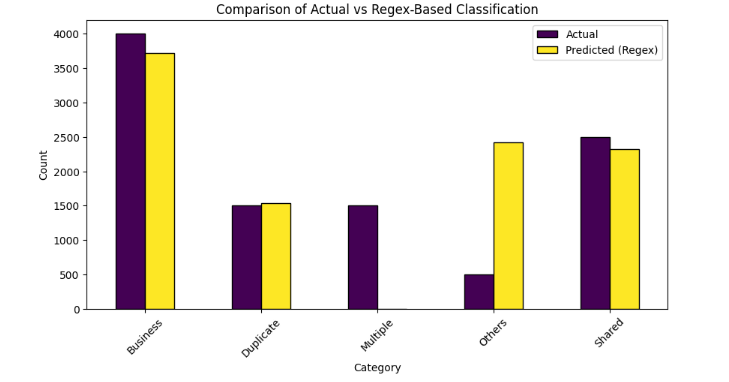

### <font color='dark green'>Training Model </font>

In [ ]:


# @title Function to train ML model
"""
Transform the 'address' column into numerical features for a machine learning model. Use these features to predict the 'category' column.
"""

# Feature extraction using character-level representation
# CountVectorizer converts text into a sparse matrix of token counts for machine learning models.

# Train Random Forest model
# Random Forest is an ensemble method that builds multiple decision trees and aggregates their results to improve accuracy.
# It is robust to noise, works well for classification tasks, and prevents overfitting.
# Train ML model
if train_df is None:
    print("Training data not available — skipping ML model training.")
    model = vectorizer = ml_acc = y_val = y_pred = None
else:
    model, vectorizer, ml_acc, y_val, y_pred = train_ml_model(train_df)
    
    def train_ml_model(train_df):
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(train_df["address"].astype(str))
        y = train_df["category"]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_train, y_train)
        print("Model training complete.")
        y_pred = model.predict(X_val)
        return model, vectorizer, accuracy_score(y_val, y_pred), y_val, y_pred


# Train ML model
        model, vectorizer, ml_acc, y_val, y_pred = train_ml_model(train_df)

In [ ]:
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots

# @title Calculate the performance of the ML model (Decision Tree)
# Evaluate model
    ml_accuracy = accuracy_score(y_val, y_pred)                           # Calculate accuracy

    print(f"Decision Tree Model Accuracy: {ml_accuracy:.4f}")

    print("Classification Report:\n", classification_report(y_val, y_pred))

**Key Metrics:**
*   **Precision:** The percentage of correctly classified addresses out of all classified as that category.
*   **Recall:** The percentage of correctly classified addresses out of the actual addresses in that category.
*   **F1-score:** The harmonic mean of precision and recall (best is 1, worst is 0).
*   **Support:** Number of test samples in each category.
*   **Accuracy:** The overall percentage of correctly classified addresses.

### <font color='dark green'>Prediction and Evaluation </font>

In [ ]:
# @title Function for predict and evaluate
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots

    def predict_and_evaluate(model, vectorizer, test_df, labeled_df):
        test_df["predicted_category"] = model.predict(vectorizer.transform(test_df["address"].astype(str)))
        accuracy = accuracy_score(labeled_df["category"], test_df["predicted_category"])
        precision = precision_score(labeled_df["category"], test_df["predicted_category"], average="weighted")
        recall = recall_score(labeled_df["category"], test_df["predicted_category"], average="weighted")
        f1 = f1_score(labeled_df["category"], test_df["predicted_category"], average="weighted")
        return test_df, accuracy, precision, recall, f1

In [ ]:
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots

    # @title Load labeled dataset for evaluation
    test_df_labeled = pd.read_csv("15k_Address_labeled_for_classification.csv")
    test_df, final_acc, precision, recall, f1 = predict_and_evaluate(model, vectorizer, test_df, test_df_labeled)

In [ ]:
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots

    # @title Save the test predictions to a CSV file for further analysis or reporting.

    test_df.to_csv("15k_Address_test_results.csv", index=False)
    print("Test predictions saved to 15k_Address_test_results.csv")

In [ ]:
# @title Compare Accuracies
"""
Compare the accuracy of a regex-based model with that of a random forest model, highlighting the improvement in performance. Display the individual accuracies and their difference.
"""

# Final Accuracy Comparison
# Compare the regex-based baseline accuracy with the Random Forest regression model accuracy
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots

    print("\n### Accuracy Comparison ###")
    print(f"Regex-only Accuracy: {regex_accuracy:.4f}")
    print(f"Decision Tree Model Accuracy: {ml_accuracy:.4f}")
    print(f"Accuracy Improvement: {ml_accuracy - regex_accuracy:.4f}")

In [ ]:
# @title Display First 10 Rows of the predicted dataset
# Display the first few rows of predictions and the distribution of predicted categories in the test data.
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots

    test_df.head(10)


In [ ]:
# @title Feature Importance Plot
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots

    # Feature Importance Plot for Decision Tree
    importances = model.feature_importances_
    feature_names = vectorizer.get_feature_names_out()

    #   Sort features by importance
    indices = np.argsort(importances)[::-1]
    top_n = 20  # Display top 20 important features

    plt.figure(figsize=(10, 6))
    plt.title("Top 20 Important Features in Address Classification Model")
    plt.bar(range(top_n), importances[indices[:top_n]], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance Score")
    plt.show()

### <font color='dark green'>Plot </font>


In [ ]:
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots
    # @title Comparison of Regex vs ML Model Accuracy
    def plot_results(regex_acc, ml_acc, y_val, y_pred):
        plt.figure(figsize=(10,5))
        sns.barplot(x=["Regex Model", "ML Model"], y=[regex_acc, ml_acc])
        plt.ylabel("Accuracy")
        plt.title("Comparison of Regex vs ML Model Accuracy")
        plt.show()

        plt.figure(figsize=(12,6))
        sns.heatmap(pd.crosstab(y_val, y_pred), annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted Category")
        plt.ylabel("Actual Category")
        plt.title("Confusion Matrix for ML Model")
        plt.show()


    # Plot results
    plot_results(regex_acc, ml_acc, y_val, y_pred)


In [ ]:
if model is None:
    print("Skipping — model not trained (data not available).")
else:
    # evaluation / plots
# @title Final evaluation metrics for Decision Tree
# Print final evaluation metrics for Decision Tree
    print(f"Final Accuracy: {final_acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

### **Comparing the models**

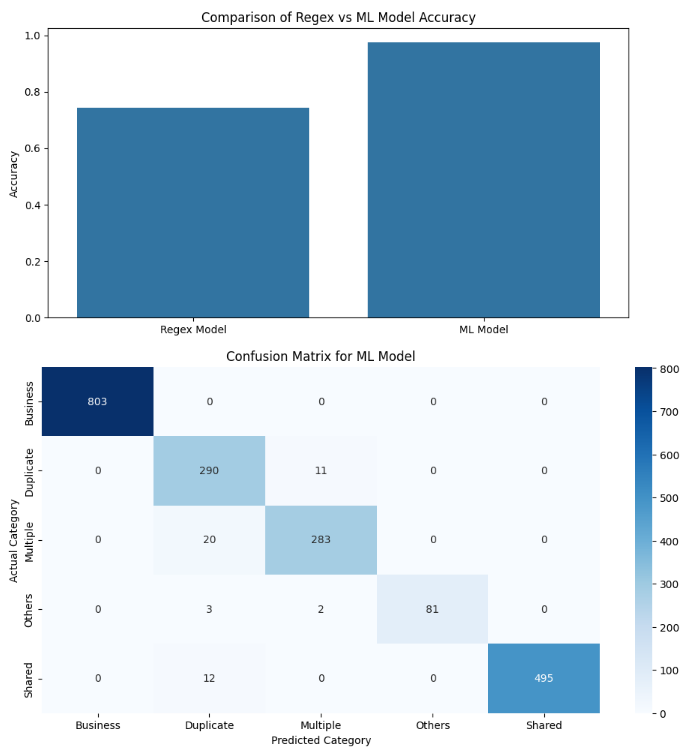